# Walkthru 13

## References
- [Walkthru 13](https://youtu.be/INrkhUGCXHg)
- [Tutorial - Assemble the data on the pets dataset](https://docs.fast.ai/tutorial.pets.html)

In [1]:
from fastai.vision.all import *
import timm

In [2]:
path = Path('paddy-disease-classification')

train_path = path / 'train_images'
train_files = get_image_files(train_path)

test_path = path/'test_images'
test_files = get_image_files(test_path).sorted()

In [3]:
get_image_files(train_path) == train_files

True

In [4]:
path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images')]

In [5]:
train_df = pd.read_csv(path / 'train.csv')
train_df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [ ]:
img2variety = { r.image_id: r.variety for _, r in train_df.iterrows() }

def get_variety(p): return img2variety[p.name]
    
img2variety.__getitem__('100330.jpg')

In [ ]:
#ImageDataLoaders.from_folder??
#ImageBlock??
#PILImage.create?
doc(aug_transforms)

### DataBlock

In [ ]:
# https://docs.fast.ai/tutorial.datablock.html

# Standard DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    # size = 128 for faster training
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

# DataBlock for predicting two labels
dblock_2labels = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    # Only one input, then, two labels
    n_inp=1,
    get_items=get_image_files,
    # Here the two labels
    get_y=[parent_label, get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    # size = 128 for faster training
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

`TransformBlock` is the basic form that stores
- `type_tfms`: happens before dataloader's time
- `item_tfms`
- `batch_tfms`  

`TransformBlock` are pipeline definitions that calls the stored transforms listed before

`ImageBlock` is a `TransformBlock` which returns
- `cls.create` as `type_tfms`
- `IntToFloatTensor` as `batch_tfms`

In [ ]:
# Simplest dblock, one TransformBlock

simplest_dblock = DataBlock(
    blocks=(TransformBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42)
)

In [ ]:
simplest_des = simplest_dblock.datasets(train_path)
simplest_des.train[0]

In [ ]:
# Simplest dblock, two TransformBlock

simplest_dblock = DataBlock(
    blocks=(TransformBlock, TransformBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42)
)

In [ ]:
simplest_des = simplest_dblock.datasets(train_path)
simplest_des.train[0]

`blocks` are batches used in training, containing input(s) and output(s).

Inputs and Outputs definitions.  
`get_x` and `get_y` are passed to `TransformBlock`'s `type_tfms`

In [ ]:
multipleio_dblock = DataBlock(
    # TransformBlock simply returns the path (simply stores things)
    blocks=(TransformBlock, TransformBlock, TransformBlock, TransformBlock),
    # Example, defining two inputs
    n_inp = 2,
    # So we can define the type_tfms 
    get_x = (lambda o: o.name, lambda o: o.name),
    # There must be two labels (block has 4 items)
    get_y = [lambda o: o.parent, lambda o: o.parent],
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

In [ ]:
multipleio_des = multipleio_dblock.datasets(train_path)
multipleio_des.train[0]

Feed the `TransformBlock` inplace:

In [ ]:
multipleio_dblock = DataBlock(
    # TransformBlock simply returns the path (simply stores things)
    blocks=(TransformBlock(type_tfms=[lambda o: o.name]), TransformBlock, TransformBlock),
    # Example, defining two inputs
    n_inp = 1,
    # There must be two labels (block has 3 items)
    get_y = [lambda o: o.parent, lambda o: o.parent],
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

In [ ]:
multipleio_des = multipleio_dblock.datasets(train_path)
multipleio_des.train[0]

`TransformBlock` defined as an equivalent `ImageBlock`

In [ ]:
not_so_simple_dblock = DataBlock(
    # This first TransformBlock is the definition of ImageBlock
    blocks=(TransformBlock(type_tfms=PILImage.create, batch_tfms=IntToFloatTensor), TransformBlock, TransformBlock),
    n_inp = 1,    
    get_y = [lambda o: o.parent, lambda o: o.parent],
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
)

In [ ]:
not_so_simple_des = not_so_simple_dblock.datasets(train_path)
not_so_simple_des.train[0]

Now, by substituting `TransformBlock` with `CategoryBlock` we transform the labels as tensors, where a categories like type of disease or variety are set as vocab objects:

In [ ]:
dblock = DataBlock(
    
    # This first TransformBlock is the definition of ImageBlock
    #blocks=(TransformBlock(type_tfms=PILImage.create, batch_tfms=IntToFloatTensor), TransformBlock, TransformBlock),
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp = 1,    
    get_y = [lambda o: o.parent.name, get_variety],
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [ ]:
des = dblock.datasets(train_path)
des.train[0]

In [ ]:
des.vocab

In [ ]:
des == dblock.datasets(train_path)

- It seems like each time it runs the splitter, the order changes
- `item_tfms` is only applied to the images

In [ ]:
img, y1, y2 = des.train[0]

In [ ]:
print(train_files[0])
print(parent_label(train_files[0]))
print(get_variety(train_files[0]))

In [ ]:
dls = dblock.dataloaders(train_path)

In [ ]:
dls.show_batch()

In [33]:
orig_lf = CrossEntropyLossFlat()

def disease_err(inp, disease, variety): return error_rate(inp[:, :10], disease)
def variety_err(inp, disease, variety): return error_rate(inp[:, 10:], variety)

def disease_loss(inp, disease, variety): return orig_lf(inp[:, :10], disease)
def variety_loss(inp, disease, variety): return orig_lf(inp[:, 10:], variety)

def loss(preds, disease, variety): return orig_lf(pred[:, :10], disease) + orig_lf(pred[:, 10:], variety)


In [34]:
err_metrics = (disease_err, variety_err)
all_metrics = err_metrics+(disease_loss, variety_loss)

In [35]:
arch = 'convnext_small_in22k'

In [36]:
learn = vision_learner(dls, arch, loss_func=loss, metrics=all_metrics, n_out=20).to_fp16()

In [37]:
m = learn.model
m[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1536, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=20, bias=False)
)

In [38]:
#learn.fine_tune(12, 0.01)

## FM - Example for predicting Normal or Sick Paddy

Applying what was learned here, lets try some things:

In [6]:
label = { r.image_id: r.label for _, r in train_df.iterrows() }

def normal_or_sick(p):
    out = 'normal'
    if label[p.name] != 'normal': out = 'sick'
    return out

In [7]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    n_inp = 1,    
    get_y = normal_or_sick,
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [8]:
des = dblock.datasets(train_path)
des.vocab

['normal', 'sick']

In [9]:
dls = dblock.dataloaders(train_path)

In [10]:
"""classes = dls.vocab
train_lbls = L(map(lambda x: classes[x[1]], dls.train_ds))
train_label_counter = Counter(train_lbls)"""

'classes = dls.vocab\ntrain_lbls = L(map(lambda x: classes[x[1]], dls.train_ds))\ntrain_label_counter = Counter(train_lbls)'

## Finetuning from resnet34 (Normal or Sick)

In [11]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

In [12]:
learn.fine_tune(10, 0.01)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

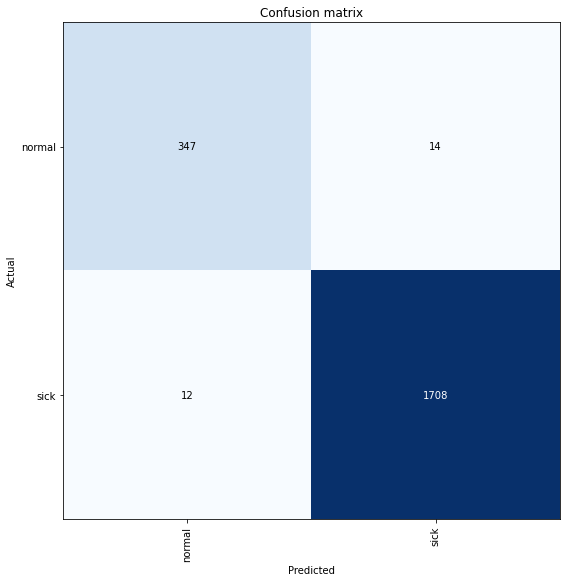

In [160]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

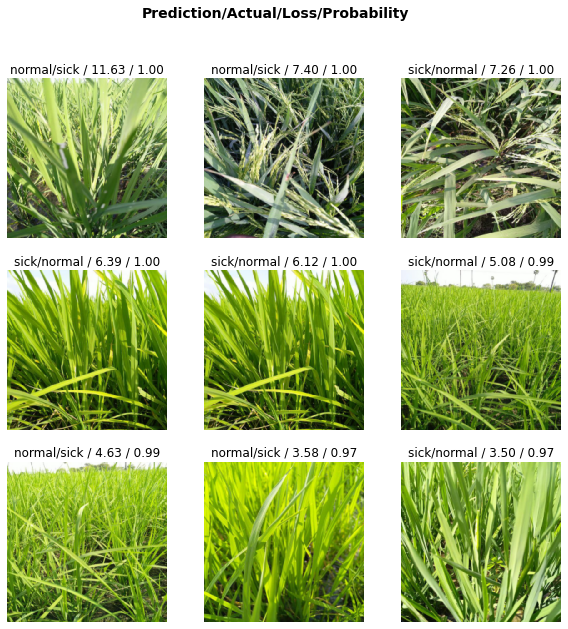

In [165]:
interp.plot_top_losses(12, figsize=(10,10))

In [27]:
get_files??